# Finding Donors for *CharityML*
### by Wenzhe Ding

CharityML is a fictitious charity organization located in the heart of Silicon Valley that was established to provide financial support for people eager to learn machine learning. After nearly 32,000 letters sent to people in the community, CharityML determined that every donation they received came from someone that was making more than $50,000 annually. To expand their potential donor base, CharityML has decided to send letters to residents of California, but to only those most likely to donate to the charity. With nearly 15 million working Californians, CharityML has brought us on board to help build an algorithm to best identify potential donors and reduce overhead cost of sending mail.
Our goal is to evaluate and optimize several different supervised learners to determine which algorithm will provide the highest donation yield while also reducing the total number of letters being sent, i.e. we to construct a model that accurately predicts whether an individual makes more than 50,000 dollars.

This sort of task can arise in a **non-profit** setting, where organizations survive on **donations**.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. We will employ several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. We will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

## Table of contents
- [Data Exploration](#Data Exploration)
- [Prepare the Data](#Prepare the Data)
   - [Transform Skewed Continuous Features](#Transform Skewed Continuous Features)
   - [Normalize Numerical Features](#Normalize Numerical Features)
   - [Shuffle and Split Data](#Shuffle and Split Data)
- [Evaluate Model Performance](#Evaluate Model Performance)
   - [Evaluation Metrics](#Evaluation Metrics)
   - [Naive Predictor](#Naive Predictor)
   - [Supervised Learning Models](#Supervised Learning Models)
   - [Create a Training and Predicting Pipeline](#Create a Training and Predicting Pipeline)
   - [Initial Model Evaluation](#Initial Model Evaluation)
- [Choose the Best Model](#Choose the Best Model)
   - [The Model in Layman's Terms](#The Model in Layman's Terms)
   - [Model Tuning](#Model Tuning)
   - [Final Model Evaluation](#Final Model Evaluation)
- [Feature Importance](#Feature Importance)
   - [Feature Selection](#Feature Selection)


----
<a id='Data Exploration'></a>
## Data Exploration
[[ go back to the top ]](#Table-of-contents)

The last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [58]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import warnings
warnings.filterwarnings('ignore')
# Import supplementary visualization code visuals.py
import visuals as vs
from pprint import pprint

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000.

In [59]:
# TODO: Total number of records
n_records = len(data)

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = len(data.loc[data.income == '>50K'])

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = n_records - n_greater_50k

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k / float(n_records) * 100

# Print the results
print ("Total number of records: {}".format(n_records))
print ("Individuals making more than $50,000: {}".format(n_greater_50k))
print ("Individuals making at most $50,000: {}".format(n_at_most_50k))
print ("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
<a id='Prepare the Data'></a>
## Prepare the Data
[[ go back to the top ]](#Table-of-contents)

Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

<a id='Transform Skewed Continuous Features'></a>
### Transform Skewed Continuous Features
[[ go back to the top ]](#Table-of-contents)

A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

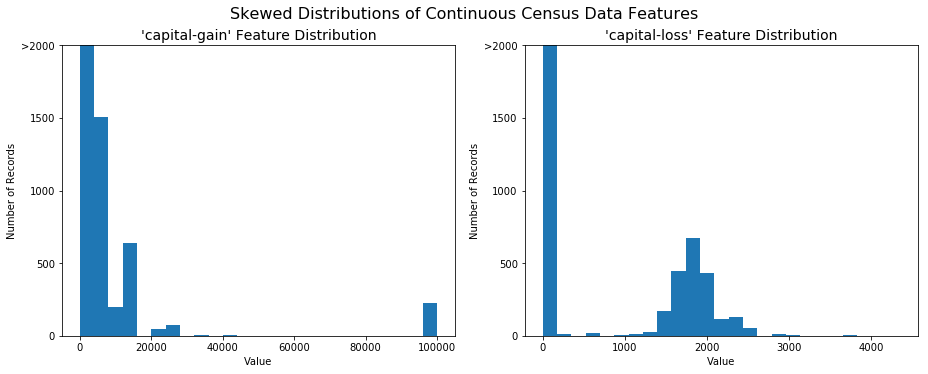

In [60]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the logarithm successfully.

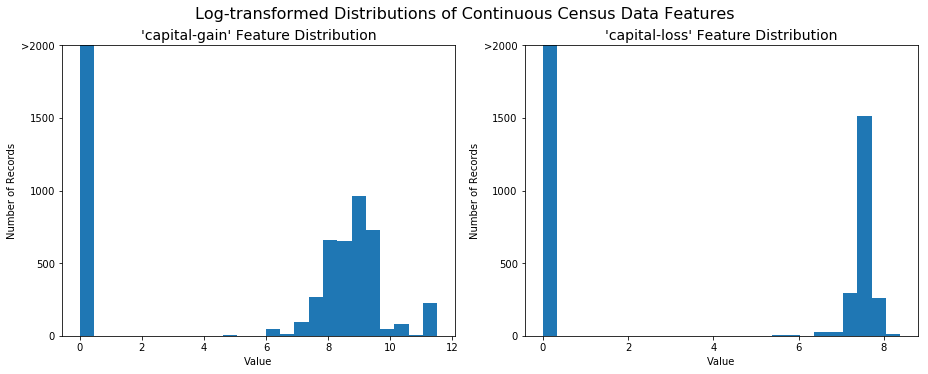

In [61]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

<a id='Normalize Numerical Features'></a>
### Normalize Numerical Features
[[ go back to the top ]](#Table-of-contents)

In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

In [62]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. We will:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [63]:
income_raw[income_raw == '<=50K'] = 0
income_raw[income_raw == '>50K'] = 1

In [64]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# TODO: Encode the 'income_raw' data to numerical values
income = income_raw

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print ("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names

103 total features after one-hot encoding.


In [65]:
print ("encoded feature names: \n")

for a,b,c in zip(encoded[:36],encoded[36:72],encoded[72:]):
    print ('{:<37}{:<37}{:<}'.format(a,b,c))

encoded feature names: 

age                                  occupation_ Armed-Forces             native-country_ Germany
education-num                        occupation_ Craft-repair             native-country_ Greece
capital-gain                         occupation_ Exec-managerial          native-country_ Guatemala
capital-loss                         occupation_ Farming-fishing          native-country_ Haiti
hours-per-week                       occupation_ Handlers-cleaners        native-country_ Holand-Netherlands
workclass_ Federal-gov               occupation_ Machine-op-inspct        native-country_ Honduras
workclass_ Local-gov                 occupation_ Other-service            native-country_ Hong
workclass_ Private                   occupation_ Priv-house-serv          native-country_ Hungary
workclass_ Self-emp-inc              occupation_ Prof-specialty           native-country_ India
workclass_ Self-emp-not-inc          occupation_ Protective-serv          native-countr

<a id='Shuffle and Split Data'></a>
### Shuffle and Split Data
[[ go back to the top ]](#Table-of-contents)


Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [66]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
<a id='Evaluate Model Performance'></a>
## Evaluate Model Performance
[[ go back to the top ]](#Table-of-contents)

In this section, we investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners, and the fourth algorithm is known as a *naive predictor*.

<a id='Evaluation Metrics'></a>
### Evaluation Metrics 
[[ go back to the top ]](#Table-of-contents)

*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for our data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

<a id='Naive Predictor'></a>
### Naive Predictor
[[ go back to the top ]](#Table-of-contents)

*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  

In [67]:
# TODO: Calculate accuracy
accuracy = sum(income == 1) / float(len(income))

# TODO: Calculate F-score using the formula above for beta = 0.5
precision = accuracy
recall = 1
fscore = (1 + pow(0.5,2)) * precision * recall / float(pow(0.5,2)*precision + recall)

# Print the results 
print ("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


<a id='Supervised Learning Models'></a>
###  Supervised Learning Models
[[ go back to the top ]](#Table-of-contents)

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) 
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

We chose Gaussian Naive Bayes, Decision Trees, and Random Forest for this problem.

The Naive Bayes classifier has been problems such as spam filtering, to mark an email as spam or non-spam. Decision Trees is widely used in the corporate finance and economic forecasting setting, for problems such as to decide whether to build a small plant or a large one to manufacture a new product. Random Forest can be used in crime prediction, meaning that to predict crime based on labeled data. 

Strength:
* Naive Bayes classifier is a fast and simple algorithm. The algorithm boils down to calculating counts for probabilities and performing some multiplication, so it is very simple to implement. And the probabilities that are needed can be calculated with a single scan of the data set and stored in a table. So model building and testing are both fast. It also scales well. Due to the independent assumption, the probability for each feature can be independently estimated. The number of parameters scales linearly with the number of features.
* Decision tree is often simple to understand and interpret. The tree induction algorithm is relatively computationally inexpensive. So training a decision tree for classification can be relatively fast.  
* Random Forest is less prone to overfitting their training set. Also, a very large number of predictors can be considered, each predictor will have at least several opportunities to be the predictor defining a split. So random forest reduced bias. It has good performance because it decorrelates the features and it generates feature importance which is helpful when interpreting the results.

Weaknesses:
* The main disadvantage of Naive Bay algorithm is that it can not learn interactions between features because it assumes  that all of the features in a data set are equally important and independent.  
* Decision tree's boundaries are rectilinear. This can limit the expressiveness of the resulting model which means that it may not be able to solve complicated classification problems that require more complex decision boundaries to be formed.  4. They prone to overfitting, especially if you have data that has lots of features and a complicated decision tree  can over fit the data. 
* Random Forest is efficient for large datasets. It is fast to train, but quite slow to create predictions once trained. More accurate ensembles require more trees, which means using the model becomes slower. 

Why this model is a good candidate?
* Naive Bayes classifier is fast to train and we can get a feel for this classification problem based on the result of Navie Bayes classifier. 
* We chose Decision Tree algorithm due to its simplicity and interpretability. 
* There are over 100 features in total, using Random Forest algorithm helps to avoid overfitting.

<a id='Create a Training and Predicting Pipeline'></a>
### Create a Training and Predicting Pipeline
[[ go back to the top ]](#Table-of-contents)

To properly evaluate the performance of each model we've chosen, it's important to create a training and predicting pipeline that allows us to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, we will implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [68]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score, fbeta_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner.fit(X_train.sample(n = sample_size, random_state = 1), \
                list(y_train.sample(n = sample_size, random_state = 1)))
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(list(y_train[:300]), predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(list(y_test), predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(list(y_train[:300]), predictions_train, beta=0.5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(list(y_test), predictions_test, beta=0.5)
       
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

<a id='Initial Model Evaluation'></a>
### Initial Model Evaluation
[[ go back to the top ]](#Table-of-contents)

In the code cell, we will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

In [69]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# TODO: Initialize the three models
clf_A =  DecisionTreeClassifier(random_state=1)
clf_B = RandomForestClassifier(random_state=1)
clf_C = GaussianNB()

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(0.01 * len(X_train))
samples_10 = int(0.1 * len(X_train))
samples_100 = len(X_train)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.


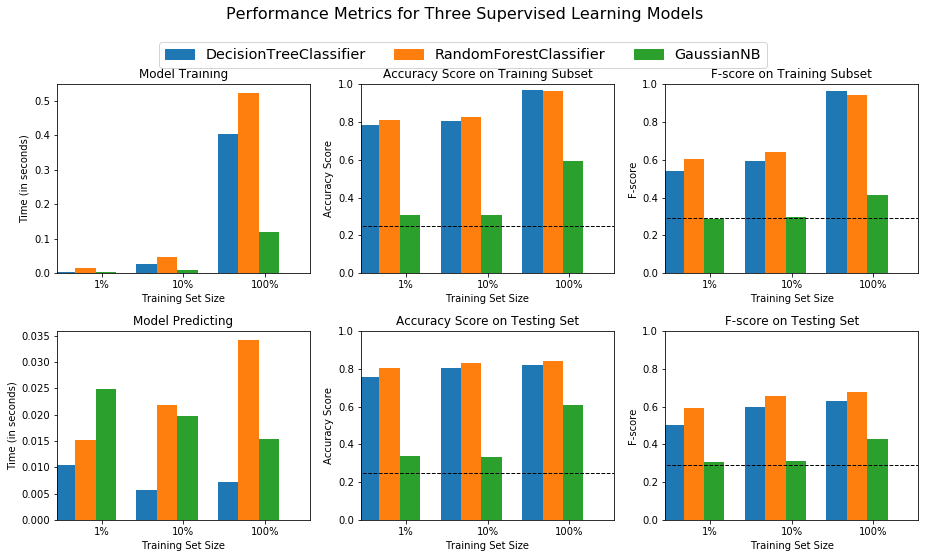

In [70]:
# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
<a id='Choose the Best Model'></a>
## Choose the Best Model
[[ go back to the top ]](#Table-of-contents)

In this final section, we will choose from the three supervised learning models the *best* model to use on the student data. We will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

Based on the evaluation we performed earlier, Decision Tree algorithm is the most appropriate model for the task of identifying individuals that make more than \$50,000. The reasons are as follows: 

First, its model training time increases as training size increases, but the magnitude is not as large as that of Random Forest algorithm. So its faster to train compared to Random Forest model. Second, it has the shortest model predicting time, which means its the fastest model to predict results once trained. Third, its accuracy scores and F-scores are much higher than those predicted by Naive Bayes and a little less than those using Random Forest. 

Even though Naive Bayes is the fastest one to train, its accuracy and F-score are so low that it is not an optimal model in this case. Comparably, Decision Tree model takes more time to train, but its performance is much better than a Naive Bayes model. Random Forest model has a better performance than Decision tree, but the difference between them is not significant. Given that Random Forest model takes much more predicting time than Decision Tree model, Decision Tree is a better choice than Random Forest. 

<a id="The Model in Layman's Terms"></a>
### The Model in Layman's Terms
[[ go back to the top ]](#Table-of-contents)

A decision tree is a classification model that uses a tree like structure to represent multiple decision paths. Traversing each path leads to a different way to classify an input sample. The goal of spliting is to get a sample as pure as possible, which means the majority of the sample have the samle label. The decision tree is constructed by repeatedly splitting a data partition into successively more homogeneous subsets.  After a tree is trained, we are able to predict the class label for a sample based on a series of conditions specified by the tree.

<a id="Model Tuning"></a>
### Model Tuning
[[ go back to the top ]](#Table-of-contents)

Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. We will need to use the entire training set for this. In the code cell below, we will implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

In [71]:
y_train = list(y_train)
y_test = list(y_test)

In [72]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer 
# TODO: Initialize the classifier
clf = DecisionTreeClassifier(random_state=1)

# TODO: Create the parameters list you wish to tune
parameters = {'max_depth': np.arange(3, 10)}

# TODO: Make an fbeta_score scoring object
scorer =  make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print ("Unoptimized model\n------")
print ("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print ("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print ("\nOptimized Model\n------")
print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print ("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8180
F-score on testing data: 0.6268

Optimized Model
------
Final accuracy score on the testing data: 0.8526
Final F-score on the testing data: 0.7228


<a id="Final Model Evaluation"></a>
### Final Model Evaluation
[[ go back to the top ]](#Table-of-contents)

The optimized models's accuracy and F-score on the testing data are 0.8526 and 0.7228 respectively. The results are better than the unoptimized model, which has 0.818 accuracy and 0.6268 F-score. In addition, the result are much better than the scores of the navie predictor, which has only 0.2478 accuracy and 0.2917 F-score. 

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |      0.2478         |      0.8180       |    0.8526       |
| F-score        |      0.2917         |      0.6268       |    0.7228       |


----
<a id="Feature Importance"></a>
## Feature Importance
[[ go back to the top ]](#Table-of-contents)

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, we expect the five most important features in descending order are 'capital-gain','capital-loss','education-num','age' and 'occupation'. A person's income directedly impact his/her capital gain and loss, so we think these two features are the most important ones determining a person's income. Factors, such as education, age and occupation could also impact a person's income, and we assume there are positive relation between a person's number of years of education and income as well as positive relation between  a person's age and income. Final, we assume that the difference in occupation can largely impact a person's income. 

We choose Decision Tree classifier as it has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

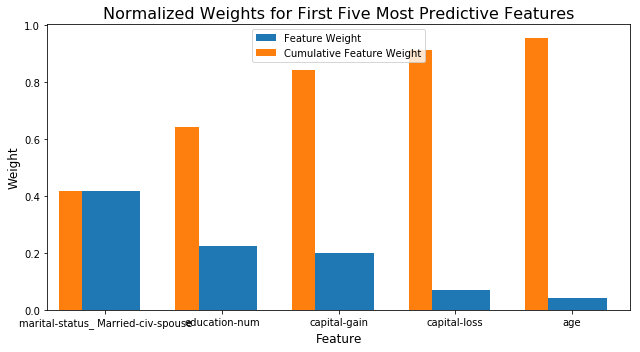

In [73]:
# TODO: Import a supervised learning model that has 'feature_importances_'

# TODO: Train the supervised model on the training set 
model = best_clf 

# TODO: Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

The visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000. There are 4 overlapped features between our assumption and the model's result. This visualization confirmed our hypothesis that a person's education duration, capital gain, capital loss and age significantly impact his/her income level. However, it is superisingly that the most important feature is 'marital-status_Married-civ-spouse' based on the model, which means that whether people have a married spouse is an important indicator of his/her income level. This probably due to the fact that only peopel over a certain age are able to get married and people who are not able to get married may be too young to make 50K. 

<a id="Feature Selection"></a>
### Feature Selection
[[ go back to the top ]](#Table-of-contents)

How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [74]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print ("Final Model trained on full data\n------")
print ("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print ("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print ("\nFinal Model trained on reduced data\n------")
print ("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print ("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8526
F-score on testing data: 0.7228

Final Model trained on reduced data
------
Accuracy on testing data: 0.8523
F-score on testing data: 0.7201


The final model's F-score and accuracy score reduced slightly using all features compare to using only five most important features. Its F-score drop from 0.8526 to 0.8523 and its accuracy score decrease from 0.7228 to 0.7201. These scores confirm the fact that these five features contribute more than half of the importance of all features present in the data. Therefore, if training time was a factor, I will consider using the reduced data as the training set. 